In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import glob
from random import randint
from utils import *
from skimage.feature import hog


## Dataset Exploration
Labeled images of vehicles and non-vehicles were obtained from [KITTI vision benchmark suit](http://www.cvlibs.net/datasets/kitti/) and [GTI vehicle image database](http://www.gti.ssr.upm.es/data/Vehicle_database.html).  
You can download the dataset for vehicles [here](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and non-vehicles [here](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip).  

-----------------------------------------------------------------------------------------------------------------------------------

Total vehicle images = 8792   
Total non-vehicle images = 8968  
Image size = 64 $\times$ 64   

The vehicle images in the database are divided as per the angle in which the images were taken. The images also reflect different lighting condiditons.   
The non-vehicle images consists of roads, trees, traffic signs, pavements or asphalts. 

In [2]:
vehicles_dir = glob.glob("./vehicles/*/*.png", recursive=True)
non_vehicles_dir = glob.glob("./non-vehicles/**/*.png", recursive=True)

print(f"The number of vehicle images = {len(vehicles_dir)}")
print(f"The number of non-vehicle images = {len(non_vehicles_dir)}")

get_img_size(vehicles_dir)
get_img_size(non_vehicles_dir)

The number of vehicle images = 8792
The number of non-vehicle images = 8968
The size of image is 64 by 64
The size of image is 64 by 64
The size of image is 64 by 64
The size of image is 64 by 64


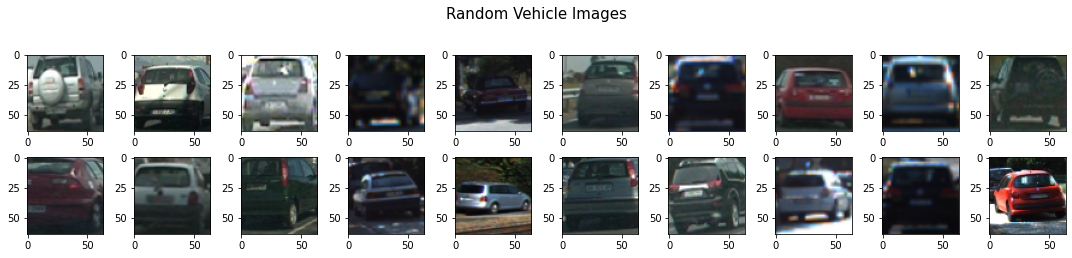

In [3]:
%run utils.py
show_random_images(image_dir = vehicles_dir,title = "Random Vehicle Images")

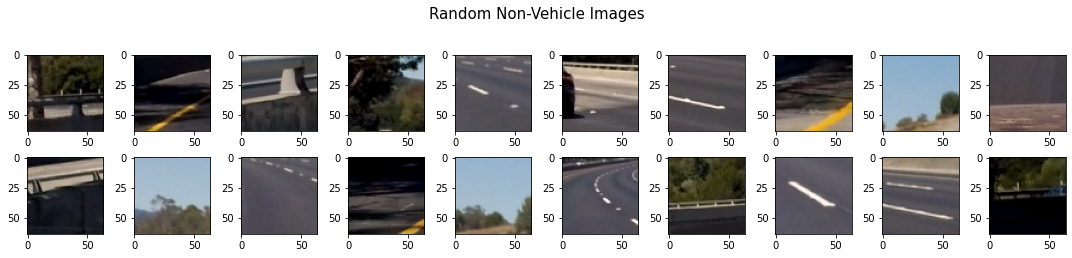

In [4]:
show_random_images(image_dir = non_vehicles_dir,title = "Random Non-Vehicle Images")

## HOG

In [5]:
%run utils.py

def image_histogram(image, bins, range=(0,256)):
	'''
	to explore color histogram across the 3 color channel
	bins: defines the number of equal-width bins in a range
	range: since the images are RGB range is set to (0,256)
	Comptes the histogram of color across the three channels nad returns a concatenated feature vector
	'''

	channel0 = np.histogram(image[:,:,0], bins, range)
	channel1 = np.histogram(image[:,:,1], bins, range)
	channel2 = np.histogram(image[:,:,2], bins, range)
	hist_color = np.concatenate((channel0[0], channel1[0], channel2[0]))
	return hist_color

def hog_features(image, orientations, pixels_per_cell, cells_per_block, visualize = True, feature_vector = True, block_norm = "L2-Hys"):

	'''
	Computes the histogram of oriented gradients. 

	Returns: features vector, corresponding hog image (hog_image)
	
	'''
	features, hog_image = hog(
								image, 
								orientations=orientations, 
								pixels_per_cell = (pixels_per_cell,pixels_per_cell), 
								cells_per_block = (cells_per_block,cells_per_block), 
								transform_sqrt = False, 
								visualize = visualize, 
								feature_vector = feature_vector, 
								block_norm = block_norm
							)

	return features, hog_image

def get_features(img_dir, cspace, orientations, pixels_per_cell, cells_per_block, hog_channel = [0,1,2], spatial_size = (32,32), bins = 32, range = (0,256)):
	features = []
	# if len(img_dir) == 1:
	image = plt.imread(img_dir)
	if cspace == "RGB":
		feature_image = image
	else:
		feature_image = change_color_space(image, cspace)

	hog_features = []
	channel_list = [hog_channel]
	print(channel_list)
	for i in range(channel_list[0]):
		channel_feature, channel_image = hog_features(feature_image[:,:,hog_channel[i]], orientations, pixels_per_cell, cells_per_block)
		hog_features.append(channel_feature)
	hog_features = np.ravel(hog_features)

	spatial_features = resize_image(feature_image, size=spatial_size)
	hist_features = image_histogram(feature_image, bins = bins, range=range)


	features.append(np.concatenate((spatial_features, hist_features,hog_features)))






In [76]:
class Parameters:
	'''
	DS to store hog parameters; Used for testing parameter configurations
	'''

	def __init__(self, color_space, orientation, pix_per_cell, cell_per_block, hog_block_norm = "L2-Hys", color_channel = [0,1,2]):
		self.orientation = orientation
		self.color_space = color_space
		self.pix_per_cell = pix_per_cell
		self.cell_per_block = cell_per_block
		self.hog_block_norm = hog_block_norm
		self.color_channel = color_channel


parameter_set = [
	Parameters("RGB", 9, 8, 2),
	Parameters("RGB", 9, 10, 2),
	Parameters("RGB", 9, 12, 2),
	Parameters("RGB", 9, 14, 2),
	Parameters("RGB", 9, 16, 2),
	Parameters("RGB", 10, 8, 2),
	Parameters("RGB", 10, 10, 2),
	Parameters("RGB", 10, 12, 2),
	Parameters("RGB", 10, 14, 2),
	Parameters("RGB", 10, 16, 2)
]


def get_hog_features_for_parameter_set(img_dir, param_set):
	'''
	For testing different hog configurations
	Takes image and parameter set and returns a multi dimensional array such that a[i] = [image, channel1HogImage, channel2HogImage, channel3HogImage, hogParameters]
	'''
	features_set = []
	img = plt.imread(img_dir)
	
	for parms in param_set:
		label = f"o = {parms.orientation}, px/c = {parms.pix_per_cell}, c/b = {parms.cell_per_block}"
		hog_viz = []
		cspace_image = change_color_space(img, parms.color_space)
		for channel in parms.color_channel:
			f, viz = hog_features(cspace_image[:,:,channel], orientations = parms.orientation, pixels_per_cell = parms.pix_per_cell, 
									cells_per_block = parms.cell_per_block)
			hog_viz.append(viz)
		
		features_set.append([cspace_image, hog_viz[0], hog_viz[1], hog_viz[2], label])
	return features_set


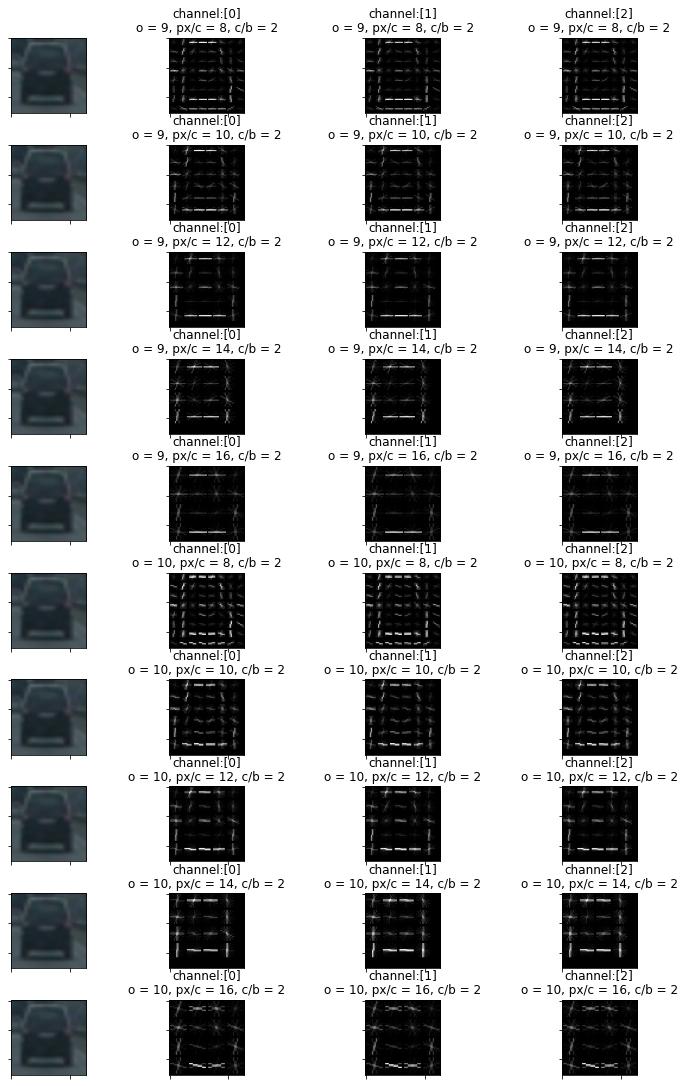

In [85]:
image = plt.imread(vehicles_dir[40])
f = get_hog_features_for_parameter_set(img_dir= vehicles_dir[40], param_set = parameter_set)
columns = 4
rows = 10
fig, ax_array = plt.subplots(rows, columns,squeeze=False, figsize=(10,15), gridspec_kw={'width_ratios': [2,4,4,4]})
fig.tight_layout()

for i,ax_row in enumerate(ax_array):
    for j,axes in enumerate(ax_row):
        axes.set_yticklabels([])
        axes.set_xticklabels([])
        try:
            axes.set_title(f"channel:[{j-1}]\n{f[i][4]}")
            img = f[i][j]
            img = np.reshape(img, (64,64))
            axes.imshow(img, cmap='gray')
        except:
            axes.set_title('')
            axes.imshow(f[i][j])
            


#         axes.plot(you_data_goes_here,'r-')
plt.show()